In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

from utils.dataloader  import FaceDataset, preprocess, postprocess
from utils.utils_data import train_validation_test_split

### Telechargement et Visualisation de notre jeu de donnée

In [19]:
faceDataset = FaceDataset(preprocess(), is_classification=True)
print(f'Taille du dataset: {len(faceDataset)}')

Taille du dataset: 43266


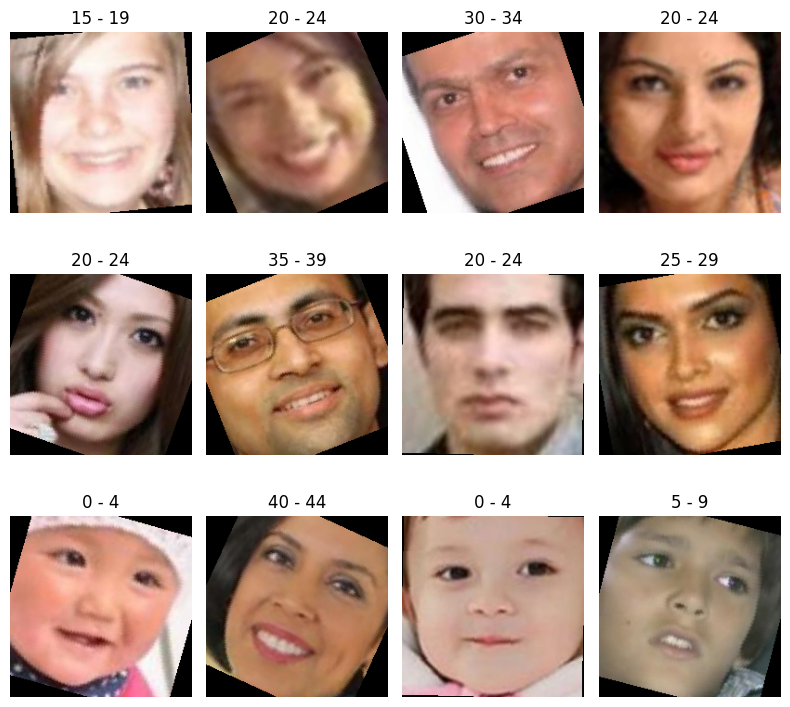

In [20]:
fig, ax = plt.subplots(3, 4, tight_layout=True, figsize=(8, 8))

label_names = faceDataset.get_all_age_range()

for i in range(3):
    for j in range(4):
        rand_idx = np.random.randint(0, len(faceDataset))
        img, label = faceDataset[rand_idx]
        postprocess_apply = postprocess()
        ax[i,j].imshow(postprocess_apply(img))
        ax[i,j].set_title(label_names[label])
        ax[i,j].set_axis_off()
        

##### Visualisation de la distribution des données

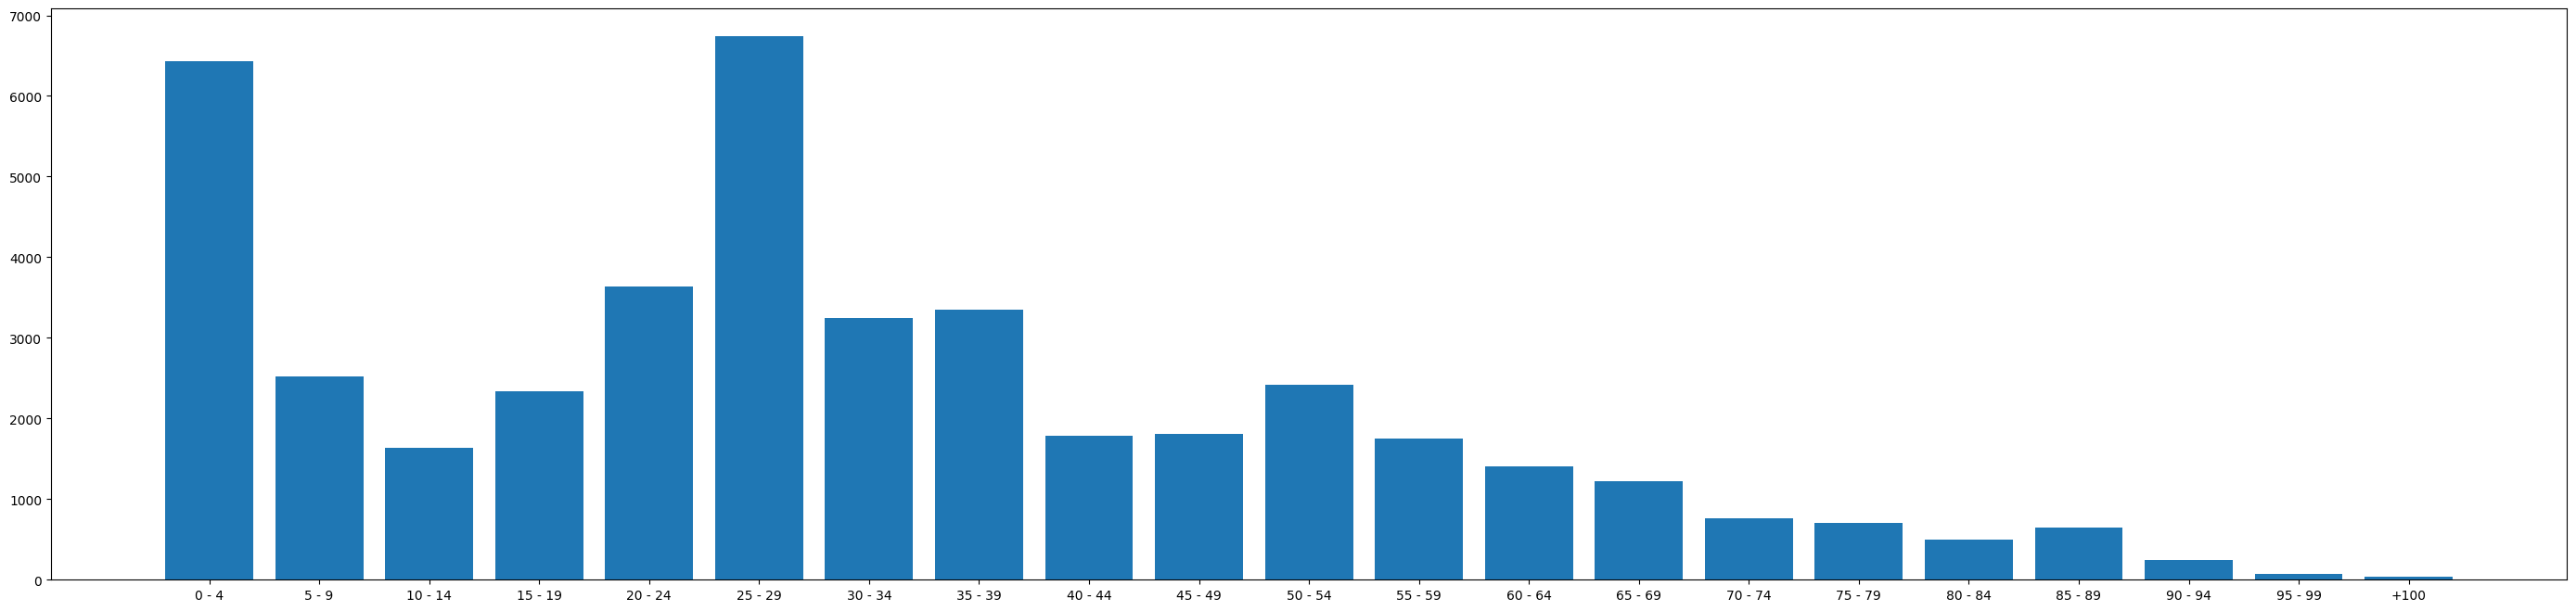

In [21]:
img_by_age_range = faceDataset.img_labels.groupby(['age_range'])['age_range']
df = img_by_age_range.count()

fig, ax = plt.subplots(figsize=(35, 8))
bar_container = ax.bar(label_names.values(), df.values)


In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

# Charger le modèle Swin Transformer préentraîné sur ImageNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.swin_t(device)




In [64]:
# Changer la dernière couche pour qu'elle corresponde au nombre de classes de notre tâche
num_classes = 21
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)



In [65]:
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset,validation_size=0.1, test_size=0.2)
batch_size = 16
# Charger les données d'entraînement et de validation


In [58]:
train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_sampler, batch_size=batch_size, shuffle=False)

train_loader = torch.utils.data.DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


In [69]:
# Définir la fonction de coût et l'optimiseur
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,)

# Fine-tuner le modèle
num_epochs = 100
for epoch in range(num_epochs):
    # Entraînement
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(images)
        print(outputs)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()
    
    # Évaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
    # Afficher les résultats de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

  0%|          | 0/1947 [00:05<?, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4153344 bytes.